# About

Here we prepare, plot (and save) the results for CI plots, which were obtained in:
- `colab_extended_ci_rf_and_gp_saving_results.ipnb`

The notebook includes both one-run and multiple-runs CIs plots

In [1]:
%ls

all_plots.ipynb
colab_extended_GPflow_pipeline.ipynb
colab_extended_ci_rf_and_gp_saving_results.ipynb
colab_extended_grid_search_pipeline.ipynb
colab_reproducing_ci_gp.ipynb
colab_reproducing_ci_rf.ipynb
colab_reproducing_grid_search_pipeline.ipynb
eda.ipynb
prepare_and_plot_extended_ci_rf_and_gp_results.ipynb
prepare_extended_grid_search_results.ipynb
prepare_reproducing_grid_search_results.ipynb


In [2]:
%ls ../data/

ESOL_README
FreeSolv_README
Lipo_README
esol_original.csv
esol_original_1024ecfp4_features.csv
esol_original_1024ecfp6_features.csv
esol_original_2048ecfp4_features.csv
esol_original_2048ecfp6_features.csv
esol_original_IdSmilesLabels.csv
esol_original_extra_features.csv
esol_original_rdkit_features.csv
freesolv_original.csv
freesolv_original_1024ecfp4_features.csv
freesolv_original_1024ecfp6_features.csv
freesolv_original_2048ecfp4_features.csv
freesolv_original_2048ecfp6_features.csv
freesolv_original_IdSmilesLabels.csv
freesolv_original_rdkit_features.csv
lipophilicity_original.csv
lipophilicity_original_1024ecfp4_features.csv
lipophilicity_original_1024ecfp6_features.csv
lipophilicity_original_2048ecfp4_features.csv
lipophilicity_original_2048ecfp6_features.csv
lipophilicity_original_IdSmilesLabels.csv
lipophilicity_original_rdkit_features.csv


## Import modules

### Standard imports

In [3]:
import json
import pickle

import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# metrics
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import jaccard_score # Tanimoto

### Custom imports

In [5]:
sys.path.insert(0, '..')

# plotting
from util_scripts.plotting_functions_and_vars import FIGSIZE_CI, FIGSIZE_HEATMAP, DPI, PLOTS_DIR
from util_scripts.plotting_functions_and_vars import datasets_to_titles, datasets_to_units, metrics_to_labels
from util_scripts.plotting_functions_and_vars import plot_algorithm_dataset_comparison_heatmap


from util_scripts.plotting_functions_and_vars import datasets_to_rounding_precision

sys.path.insert(0, './notebooks')

## Set plotting style

In [6]:
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='w'
#plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.edgecolor']='w'
plt.rcParams['figure.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
#plt.rcParams['grid.color']='white'

# sns.set()

# Load Data

## CHOOSE: dataset, smile_type, grid_search_type

In [7]:
dataset = 'freesolv'
assert dataset in ['freesolv', 'esol', 'lipophilicity']

smile_type = 'original'
assert smile_type in ['original', 'protonated']

grid_search_type = 'extended'
assert grid_search_type in ['reproducing', 'extended']

# correlated features treatment
if dataset == 'esol':
    cf = 'reduced'
else:
    cf = 'full'
assert cf in ['reduced', 'full']

In [8]:
# # for esol
# cf = 'full'

## Titles, Units and Labels for datasets

In [9]:
for key, value in datasets_to_titles.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

freesolv      :  Solvation Energy
esol          :  Log Solubility
lipophilicity :  Octanol/Water Distribution Coefficient


In [10]:
for key, value in datasets_to_units.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

freesolv      :  (kcal/mol)
esol          :  (mol/litre)
lipophilicity :  (logD)


In [11]:
for key, value in metrics_to_labels.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

RMSE          :  root-mean-square error
MAE           :  mean absolute error
R^2           :  R^2 (coefficient of determination)
pearson_r     :  Pearson correlation


In [12]:
rp = datasets_to_rounding_precision[dataset]
rp

3

## CHOOSE metric to display

In [13]:
metric = 'RMSE'
assert metric in metrics_to_labels

In [14]:
if metric in ['RMSE', 'MAE']:
    pass
else:
    # no units
    datasets_to_units = {'freesolv': '', 'esol': '', 'lipophilicity': ''}

## Choose model to show

In [15]:
model = 'gp'
assert model in ['rf', 'gp']

In [16]:
models_to_title_additions = {
    'rf': 'Random Forests',
    'gp': 'Gaussian Processes'
}

## Load files:

In [17]:
print(dataset, smile_type, grid_search_type, cf, model)

lipophilicity original extended full gp


In [18]:
# save results as csv-s, rewrite each time
df_true = pd.read_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_true_{model}.csv')
df_pred = pd.read_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_pred_{model}.csv')
df_std = pd.read_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_std_{model}.csv')

## Have a look at files

In [19]:
df_true.shape, df_pred.shape, df_std.shape

((840, 10), (840, 10), (840, 10))

In [20]:
df_true.head()

,test_true_0,test_true_1,test_true_2,test_true_3,test_true_4,test_true_5,test_true_6,test_true_7,test_true_8,test_true_9
0,2.63,1.71,3.30,-0.72,3.20,2.16,3.99,0.70,0.02,1.09
1,-0.91,1.90,1.26,0.75,4.24,2.12,4.20,2.60,2.66,1.92
2,3.21,2.10,2.34,2.71,1.81,0.98,1.57,3.80,1.91,1.00
3,2.90,0.78,0.80,2.50,-0.71,2.02,0.68,1.69,2.95,3.54
4,3.07,0.75,2.41,3.32,2.32,2.80,2.50,2.46,3.10,3.10


In [21]:
df_pred.head()

,test_pred_0,test_pred_1,test_pred_2,test_pred_3,test_pred_4,test_pred_5,test_pred_6,test_pred_7,test_pred_8,test_pred_9
0,1.814484,1.560232,2.626313,-0.438415,3.684169,1.225403,3.942793,0.742869,0.465576,1.219827
1,2.295975,2.719249,1.550028,2.021196,3.379340,2.782881,3.606230,2.415748,2.487345,2.106283
2,2.081986,0.069870,2.269750,2.484678,1.818954,2.408998,2.480483,2.835271,3.185043,1.845507
3,2.649463,1.196011,0.829539,2.469708,-1.197828,1.891777,1.120023,1.949703,3.473320,3.205242
4,2.410016,1.197083,2.150850,3.208492,1.821601,2.150973,2.434735,2.259835,3.066788,3.291047


In [22]:
df_std.head()

,test_std_0,test_std_1,test_std_2,test_std_3,test_std_4,test_std_5,test_std_6,test_std_7,test_std_8,test_std_9
0,0.764980,0.552851,0.601321,0.653349,0.448401,1.001286,0.452757,0.582171,0.521291,0.751181
1,0.599953,0.568797,0.631491,0.824830,0.788718,0.579185,0.475184,0.543185,0.532406,0.359175
2,0.619349,1.033181,0.551670,0.487927,0.342431,0.447662,0.778293,0.464286,0.503754,0.819690
3,0.402291,0.346103,0.576513,0.526777,0.643768,0.627200,0.413689,0.392316,0.467734,0.695549
4,0.547154,0.504327,0.538563,0.498076,0.709210,0.509988,0.536514,0.460465,0.418188,0.456830


# One run

In [23]:
y_test = df_true.iloc[:, 0]
y_test_pred = df_pred.iloc[:, 0]
y_test_std = df_std.iloc[:, 0]

## RMSE

In [24]:
mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)

0.6315905178412844

## Calculate confidence bounds using std part of gpr predictions

In [25]:
upper = y_test_pred + 1.96 * y_test_std
lower = y_test_pred - 1.96 * y_test_std

In [26]:
CIs_df = pd.DataFrame(
    {'y_test': y_test,
     'y_test_pred': y_test_pred,
     'y_test_std': y_test_std,
     'lower': lower,
     'upper': upper,
     'sq_error': (y_test - y_test_pred) ** 2
     }
)
CIs_df = CIs_df.sort_values(by='y_test_std', ascending=True)
CIs_df['cumul_sq_error'] = CIs_df['sq_error'].cumsum()
CIs_df['cumul_mse'] = CIs_df['cumul_sq_error'].values / np.arange(1, CIs_df.shape[0]+1)
CIs_df['cumul_rmse'] = np.sqrt(CIs_df['cumul_mse'])
display(CIs_df)

,y_test,y_test_pred,y_test_std,lower,upper,sq_error,cumul_sq_error,cumul_mse,cumul_rmse
803,3.17,3.195775,0.312898,2.582495,3.809056,0.000664,0.000664,0.000664,0.025775
145,-0.30,-0.211957,0.316737,-0.832763,0.408848,0.007752,0.008416,0.004208,0.064869
797,1.21,1.410819,0.317429,0.788658,2.032980,0.040328,0.048744,0.016248,0.127468
530,2.80,2.572390,0.318399,1.948328,3.196451,0.051806,0.100551,0.025138,0.158549
63,3.08,3.068266,0.320044,2.440980,3.695551,0.000138,0.100688,0.020138,0.141907
...,...,...,...,...,...,...,...,...,...
708,1.80,0.211420,1.036938,-1.820978,2.243818,2.523588,332.535103,0.397769,0.630690
616,0.20,0.015506,1.037440,-2.017877,2.048889,0.034038,332.569141,0.397335,0.630345
762,0.40,0.013391,1.037445,-2.020002,2.046783,0.149467,332.718608,0.397039,0.630110
541,1.23,0.013727,1.037447,-2.019670,2.047123,1.479321,334.197929,0.398329,0.631133


In [27]:
# checking that calculating rmse each time separately would be the same
CIs_df = CIs_df.sort_values(by='y_test_std', ascending=True)


calculation_match = []
for i in range(CIs_df.shape[0]):
    a = CIs_df.y_test[:i+1]
    b = CIs_df.y_test_pred[:i+1]
    
    calculation_match.append(np.abs(mean_squared_error(a, b, squared=False) - CIs_df.cumul_rmse.iloc[i]) < 1e-8)
    
# if returns true - it is the same
assert np.all(calculation_match) 

## Plot test observations with sdt values as colours

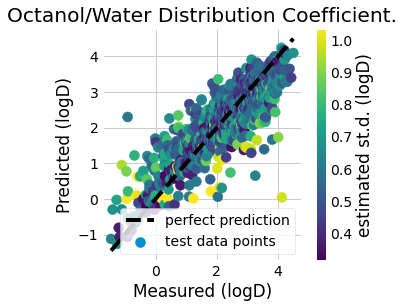

In [28]:
# sort values used for x axis
CIs_df = CIs_df.sort_values(by='y_test')

# Plot error bars for predicted quantity using unbiased variance
plt.figure(figsize=FIGSIZE_CI)

plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')
plt.scatter(x=CIs_df.y_test, y=CIs_df.y_test_pred, c=CIs_df.y_test_std, s=100, label='test data points')

plt.xlabel(f'Measured {datasets_to_units[dataset]}')
plt.ylabel(f'Predicted {datasets_to_units[dataset]}')
plt.title(f'{datasets_to_titles[dataset]}.')

# add colourbar and legend
plt.colorbar(label=f'estimated st.d. {datasets_to_units[dataset]}')
plt.legend()

plt.savefig(f'{PLOTS_DIR}/ci_plots/predicted_vs_measured_scatter_colour_conf_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()

## Plot sq^error vs std

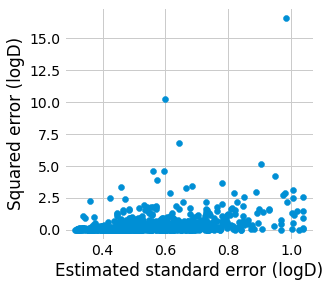

In [29]:
# sort values used for x axis
CIs_df = CIs_df.sort_values(by='y_test_std')

# Plot error bars for predicted quantity using unbiased variance
plt.figure(figsize=FIGSIZE_CI)

#plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')
plt.scatter(x=CIs_df.y_test_std, y=CIs_df.sq_error)


plt.xlabel(f'Estimated standard error {datasets_to_units[dataset]}')
plt.ylabel(f'Squared error {datasets_to_units[dataset]}')
# plt.title(f'{datasets_to_titles[dataset]}')

# # add colourbar and legend
# plt.colorbar()
# plt.legend()

#plt.savefig(f'{PLOTS_DIR}/pubs_units_values.png', bbox_inches='tight')
plt.show()

## Plot 95% confidence intervals

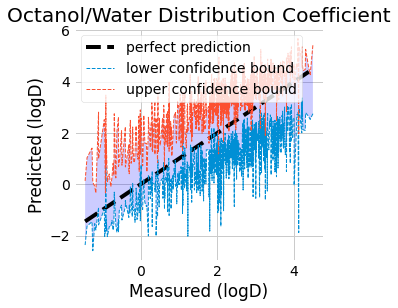

In [30]:
# sort values used for x axis
CIs_df = CIs_df.sort_values(by='y_test')

fig, ax = plt.subplots(1, figsize=FIGSIZE_CI)

# ax.set_aspect('equal')

ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')

ax.plot(CIs_df.y_test, CIs_df.lower, linewidth=1, linestyle='--', label='lower confidence bound')
ax.plot(CIs_df.y_test, CIs_df.upper, linewidth=1, linestyle='--', label='upper confidence bound')
ax.fill_between(CIs_df.y_test, CIs_df.upper, CIs_df.lower, facecolor='blue', alpha=0.2)




ax.set_title(f'{datasets_to_titles[dataset]}')
ax.set_xlabel(f'Measured {datasets_to_units[dataset]}')
ax.set_ylabel(f'Predicted {datasets_to_units[dataset]}')

ax.legend(loc='upper left')

#plt.savefig(f'{PLOTS_DIR}/ci_plots/predicted_vs_measured_with_ci_bounds_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()

## Calculate the proportion of measured values in test set within 95% CIs

In [31]:
within_cis = (CIs_df.lower <= CIs_df.y_test) & (CIs_df.y_test <= CIs_df.upper)
within_cis.sum() / len(within_cis)

0.9428571428571428

## Confidence plots (RMSE vs Prcentile)

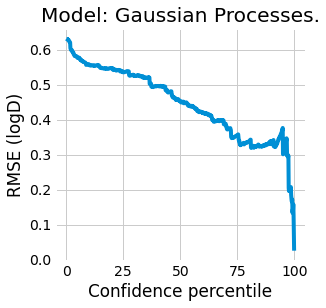

In [32]:
# sort values used for x axis
CIs_df = CIs_df.sort_values(by='y_test_std', ascending=True)

# set size
plt.figure(figsize=FIGSIZE_CI)

confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))
flipped_cumul_rmse = CIs_df['cumul_rmse'].values[::-1]


plt.plot(confidence_percentiles, flipped_cumul_rmse)
plt.title(f'Model: {models_to_title_additions[model]}.')
plt.xlabel('Confidence percentile')
plt.ylabel(f'RMSE {datasets_to_units[dataset]}')


plt.savefig(f'{PLOTS_DIR}/ci_plots/cumulrmse_vs_confidence_one_run_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()

In [33]:
corr, p_value = pearsonr(confidence_percentiles, flipped_cumul_rmse)
corr, p_value

(-0.9654133582224588, 0.0)

# Multiple runs

In [34]:
dataset_to_num_cis = {
    'freesolv': 50,
    'esol': 30,
    'lipophilicity': 10
}

In [35]:
dataset_to_num_cis[dataset]

10

In [36]:
rmse_mult_runs = []
within_95_cis_mult_runs = []
cumulrmse_vs_percentile_corr_mult_runs = []

flipped_cumulrmse_mult_runs = []

for i in range(dataset_to_num_cis[dataset]):
    
    # get data
    y_test = df_true.iloc[:, i]
    y_test_pred = df_pred.iloc[:, i]
    y_test_std = df_std.iloc[:, i]
    
    # calculate and record rmse
    rmse_mult_runs.append(mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False))
    
    # calculate upper and lower 95% conf bounds
    upper = y_test_pred + 1.96 * y_test_std
    lower = y_test_pred - 1.96 * y_test_std
    
    # calculate and record proportion of true values within 95% CI from prediction
    within_cis = (lower <= y_test) & (y_test <= upper)
    within_cis_proportion = within_cis.sum() / len(within_cis)
    within_95_cis_mult_runs.append(within_cis_proportion)
    
    # create a dataframe to be able to sort things easily
    CIs_df = pd.DataFrame(
        {'y_test': y_test,
         'y_test_pred': y_test_pred,
         'y_test_std': y_test_std,
         'lower': lower,
         'upper': upper,
         'sq_error': (y_test - y_test_pred) ** 2
        }
    )
    
    # create cumulative rmse column
    CIs_df = CIs_df.sort_values(by='y_test_std', ascending=True)
    CIs_df['cumul_sq_error'] = CIs_df['sq_error'].cumsum()
    CIs_df['cumul_mse'] = CIs_df['cumul_sq_error'].values / np.arange(1, CIs_df.shape[0]+1)
    CIs_df['cumul_rmse'] = np.sqrt(CIs_df['cumul_mse'])
    
    # record confidence percentiles and flip cumulative rmses
    confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))
    flipped_cumul_rmse = CIs_df['cumul_rmse'].values[::-1]
    
    # record flipped cumulative rmse
    flipped_cumulrmse_mult_runs.append(flipped_cumul_rmse)
    
    # record correlation between cumulative rmse and confidence percentile
    cumulrmse_vs_percentile_corr_mult_runs.append(pearsonr(confidence_percentiles, flipped_cumul_rmse)[0])

print('Done')

Done


# Important metrics (corr, rmse, within_95)

In [37]:
dataset, cf, model

('lipophilicity', 'full', 'gp')

## Correlation

In [38]:
#cumulrmse_vs_percentile_corr_mult_runs

In [39]:
np.mean(cumulrmse_vs_percentile_corr_mult_runs).round(3), np.std(cumulrmse_vs_percentile_corr_mult_runs).round(3)

(-0.973, 0.016)

## RMSE

In [40]:
#rmse_mult_runs

In [41]:
np.mean(rmse_mult_runs).round(3), np.std(rmse_mult_runs).round(3)

(0.637, 0.024)

## Within 95% CIs

In [42]:
#within_95_cis_mult_runs

In [43]:
np.mean(within_95_cis_mult_runs).round(3), np.std(within_95_cis_mult_runs).round(3)

(0.938, 0.009)

# Separate plots (do not save)

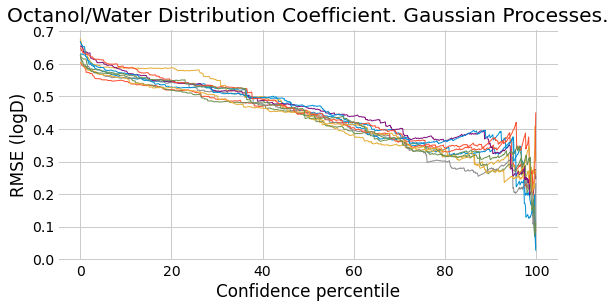

In [44]:
# set size
plt.figure(figsize=FIGSIZE_HEATMAP)

for flipped_cumul_rmse in flipped_cumulrmse_mult_runs:
    plt.plot(confidence_percentiles, flipped_cumul_rmse, linewidth=1)

plt.title(f'{datasets_to_titles[dataset]}. {models_to_title_additions[model]}.')
plt.xlabel('Confidence percentile')
plt.ylabel(f'RMSE {datasets_to_units[dataset]}')


#plt.savefig(f'{PLOTS_DIR}/ci_plots/cumulrmse_vs_confidence_mult_run_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()

# Calculations for Confidence Plot

In [45]:
#print(np.array(flipped_cumulrmse_mult_runs).shape)
#print(np.array(flipped_cumulrmse_mult_runs).std(axis=0).shape)
#print(np.array(flipped_cumulrmse_mult_runs).mean(axis=0).shape)

flipped_cumulrmse_mean = np.array(flipped_cumulrmse_mult_runs).mean(axis=0)
flipped_cumulrmse_sdt = np.array(flipped_cumulrmse_mult_runs).mean(axis=0)

flipped_cumulrmse_lower = flipped_cumulrmse_mean - 1.96*flipped_cumulrmse_sdt
flipped_cumulrmse_upper = flipped_cumulrmse_mean + 1.96*flipped_cumulrmse_sdt

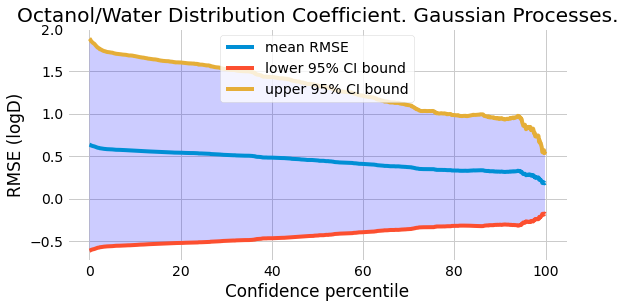

In [46]:
# set size
plt.figure(figsize=FIGSIZE_HEATMAP)

plt.plot(confidence_percentiles, flipped_cumulrmse_mean, label=f'mean {metric}')
plt.plot(confidence_percentiles, flipped_cumulrmse_lower, label=f'lower 95% CI bound')
plt.plot(confidence_percentiles, flipped_cumulrmse_upper, label=f'upper 95% CI bound')
plt.fill_between(confidence_percentiles, flipped_cumulrmse_upper, flipped_cumulrmse_lower, facecolor='blue', alpha=0.2)

plt.legend(loc='upper center')

plt.title(f'{datasets_to_titles[dataset]}. {models_to_title_additions[model]}.')
plt.xlabel('Confidence percentile')
plt.ylabel(f'RMSE {datasets_to_units[dataset]}')

#plt.savefig(f'{PLOTS_DIR}/ci_plots/cumulrmse_vs_confidence_with_ci_bounds_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()

### Together

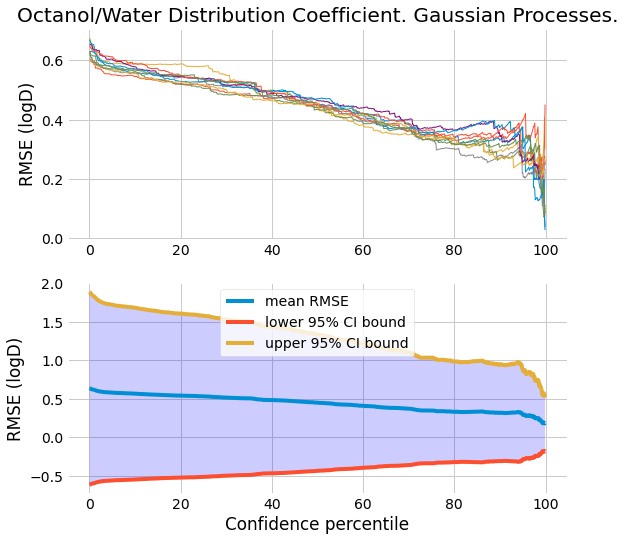

In [47]:
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8)) #, sharey=True

for flipped_cumul_rmse in flipped_cumulrmse_mult_runs:
    ax1.plot(confidence_percentiles, flipped_cumul_rmse, linewidth=1)

ax1.set_title(f'{datasets_to_titles[dataset]}. {models_to_title_additions[model]}.')
#ax1.set_xlabel('Confidence percentile')
ax1.set_ylabel(f'RMSE {datasets_to_units[dataset]}')


ax2.plot(confidence_percentiles, flipped_cumulrmse_mean, label=f'mean {metric}')
ax2.plot(confidence_percentiles, flipped_cumulrmse_lower, label=f'lower 95% CI bound')
ax2.plot(confidence_percentiles, flipped_cumulrmse_upper, label=f'upper 95% CI bound')
ax2.fill_between(confidence_percentiles, flipped_cumulrmse_upper, flipped_cumulrmse_lower, facecolor='blue', alpha=0.2)

ax2.legend(loc='upper center')

#ax2.set_title(datasets_to_titles[dataset])
ax2.set_xlabel('Confidence percentile')
ax2.set_ylabel(f'RMSE {datasets_to_units[dataset]}')

plt.savefig(f'{PLOTS_DIR}/ci_plots/cumulrmse_vs_confidence_multiple_runs_both_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()